# Лабораторна робота №3

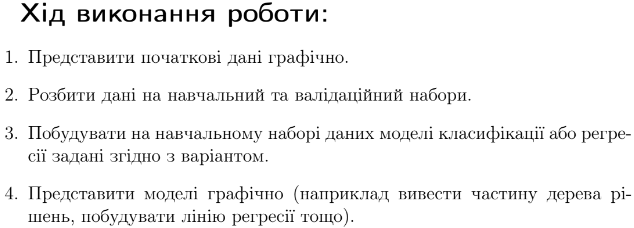

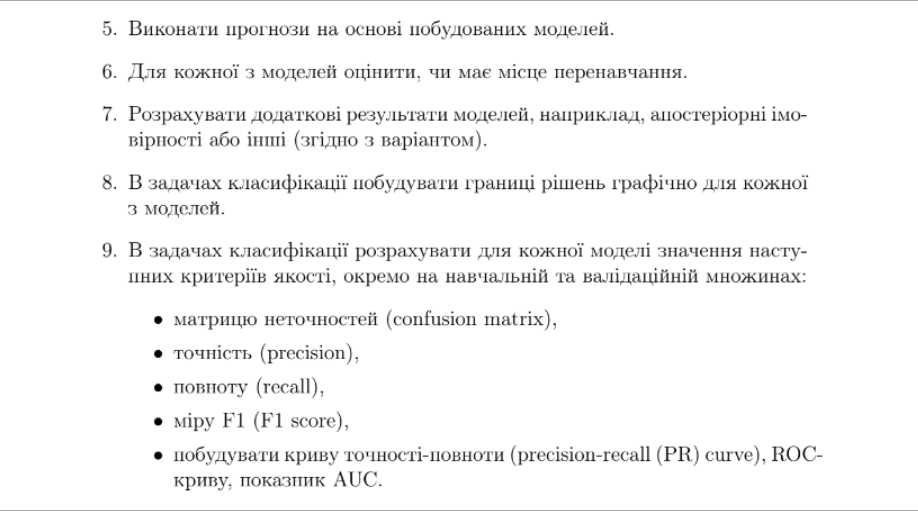



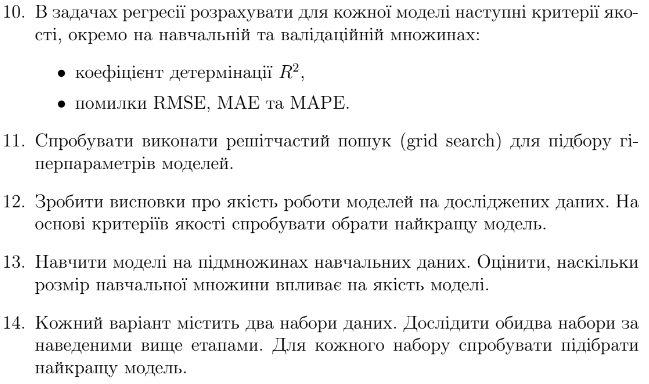


### Варіант №12

Побудувати моделi регресiї на основi методу опорних векторiв:

- Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.

- Настроїти гiперпараметри epsilon i C, використовуючи решiтчастий пошук.

## Виконання:

## 1. Shanghai license plate price

In [4]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,Date,Total number of license issued,lowest price,avg price,Total number of applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Date                            204 non-null    object
 1   Total number of license issued  204 non-null    int64 
 2   lowest price                    204 non-null    int64 
 3   avg price                       204 non-null    int64 
 4   Total number of applicants      204 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.1+ KB


In [6]:
data.describe()

,Total number of license issued,lowest price,avg price,Total number of applicants
count,204.000000,204.000000,204.000000,204.000000
mean,7634.323529,53375.000000,54358.044118,66769.436275
std,2615.136371,24577.035068,23772.554894,85081.873379
min,1400.000000,8100.000000,14057.000000,3525.000000
25%,5958.250000,34050.000000,34932.000000,10457.250000
50%,7876.500000,45050.000000,46036.500000,19324.000000
75%,9000.000000,77950.000000,78142.000000,115978.250000
max,16000.000000,93500.000000,93540.000000,277889.000000


## Початкові дані графічно

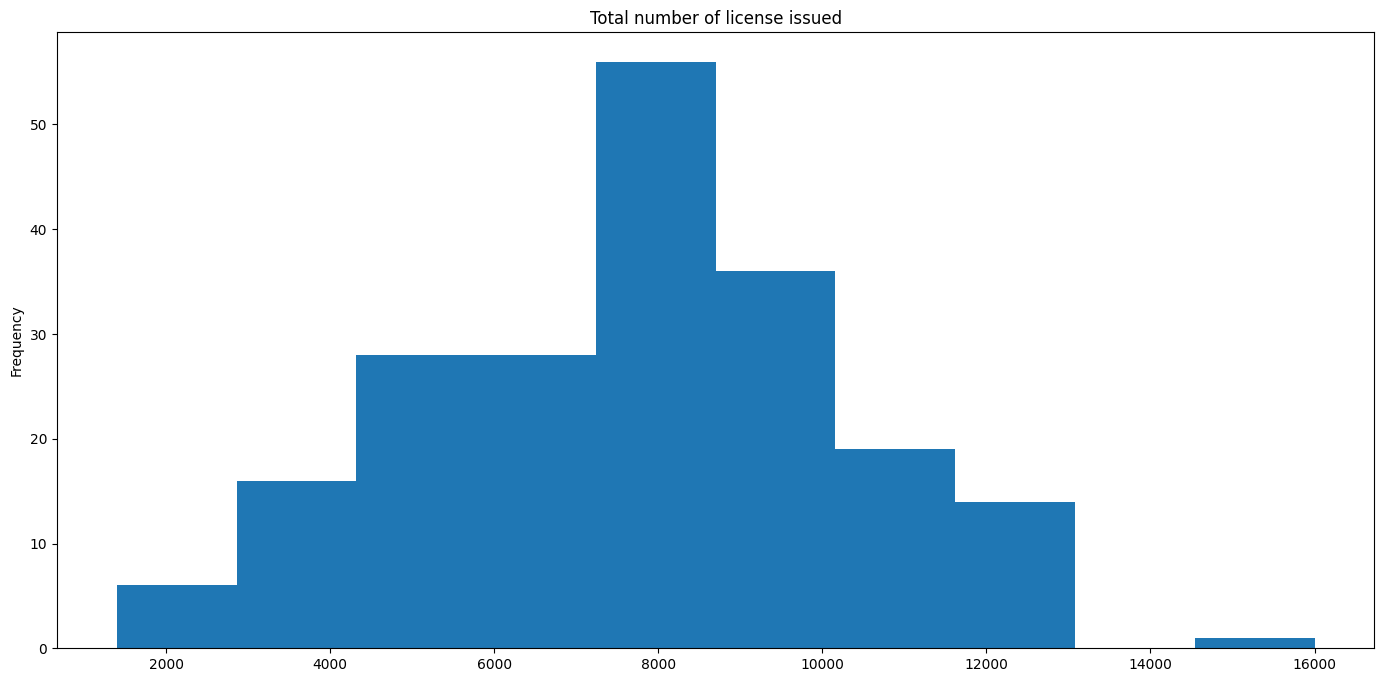

In [7]:
#Будуємо гістограму залежності середньої ціни від року
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
data["Total number of license issued"].plot(kind = "hist");
plt.title("Total number of license issued");

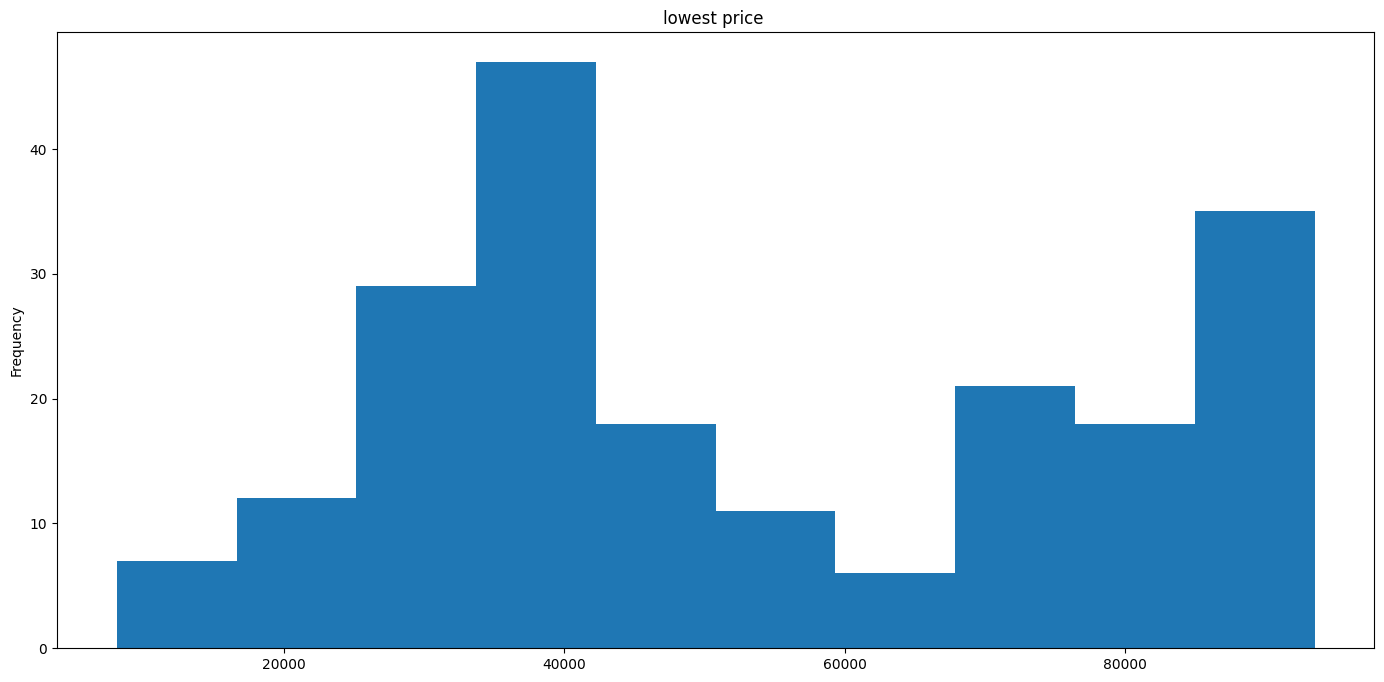

In [8]:
plt.figure(figsize=(17,8))
data["lowest price "].plot(kind = "hist");
plt.title("lowest price ");

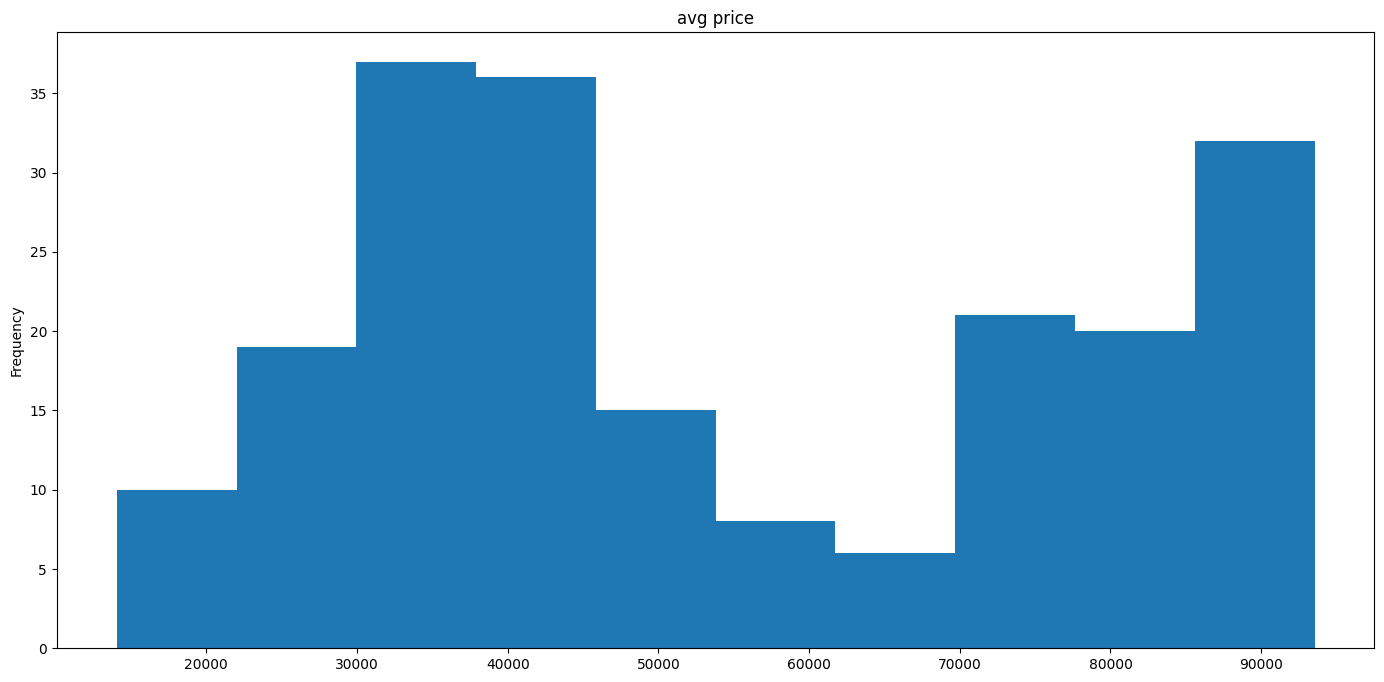

In [9]:
plt.figure(figsize=(17,8))
data["avg price"].plot(kind = "hist");
plt.title("avg price");

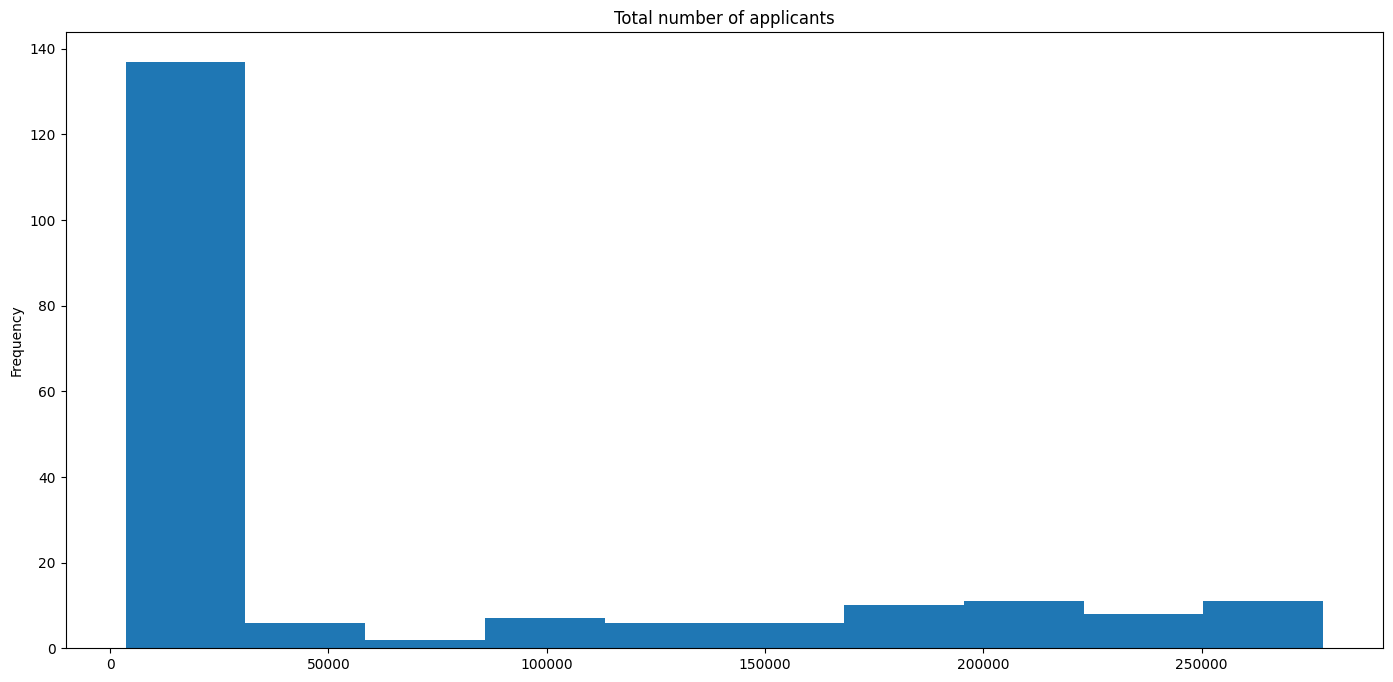

In [10]:
plt.figure(figsize=(17,8))
data["Total number of applicants"].plot(kind = "hist");
plt.title("Total number of applicants");

також побудуємо scatter_matrix, а також кореляційну матрицю

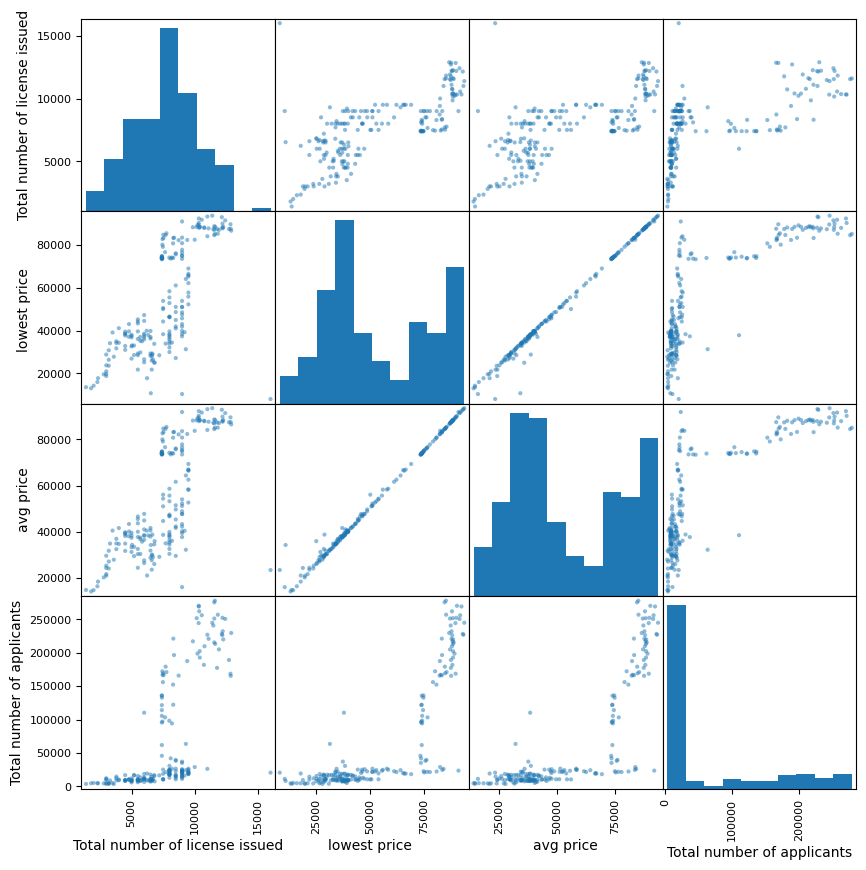

In [11]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize = (10, 10));

In [12]:
data.corr()

,Total number of license issued,lowest price,avg price,Total number of applicants
Total number of license issued,1.000000,0.720451,0.738741,0.649152
lowest price,0.720451,1.000000,0.995960,0.814285
avg price,0.738741,0.995960,1.000000,0.817585
Total number of applicants,0.649152,0.814285,0.817585,1.000000


Бачимо дуже сильну лінійну залежність між цільовим атрибутом avg price та lowest price. Як би в завданні не було потрібно використовувати лише SVR(kernel = "poly"), то можна було б навчити однофакторну лінійну регресійну модель, де відкликом є avg price, а фактором - lowest price

## Препроцесінг та розбиття датасету на навчальний та валідаційний набори

Опис даних з каглу:

Шанхай використовує систему аукціонів для продажу обмеженої кількості номерних знаків покупцям автомобілів на викопному паливі щомісяця. Середня ціна цього номерного знаку становить близько 13 000 доларів, і його часто називають "найдорожчим шматком металу у світі". Отже, наша мета - спрогнозувати середню ціну або найнижчу ціну на наступний місяць.

In [13]:
data["Date"].value_counts()

Jan-02    1
Oct-13    1
Dec-12    1
Jan-13    1
Feb-13    1
         ..
Nov-07    1
Dec-07    1
Jan-08    1
Mar-08    1
Jan-19    1
Name: Date, Length: 204, dtype: int64

In [14]:
Date = data["Date"].value_counts()
Date.where(Date > 1)

Jan-02   NaN
Oct-13   NaN
Dec-12   NaN
Jan-13   NaN
Feb-13   NaN
          ..
Nov-07   NaN
Dec-07   NaN
Jan-08   NaN
Mar-08   NaN
Jan-19   NaN
Name: Date, Length: 204, dtype: float64

Створимо з даного атрибуту категоріальний, розподіливши його на 4 сезони: зима, весна, літо, осінь. Спочатку залишимо тільки назви місяців

In [15]:
import warnings

data_copy = data.copy()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(data["Date"])):
        data_copy["Date"][i] = data_copy["Date"][i][:3]

data_copy["Date"]

0      Jan
1      Feb
2      Mar
3      Apr
4      May
      ... 
199    Sep
200    Oct
201    Nov
202    Dec
203    Jan
Name: Date, Length: 204, dtype: object

Поміняємо назви місяців на сезони:

In [16]:
import numpy as np

winter_months = ["Dec", "Jan", "Feb"]
spring_months = ["Mar", "Apr", "May"]
summer_months = ["Jun", "Jul", "Aug"]
fall_months   = ["Sep", "Oct", "Nov"]

months = {"winter": winter_months,
          "spring": spring_months,
          "summer": summer_months,
          "fall": fall_months
}

for key in months.keys():
    
    for month in months[key]:
        data_copy["Date"].replace(month, key, inplace = True)

In [17]:
data_copy["Date"].value_counts()

winter    51
spring    51
summer    51
fall      51
Name: Date, dtype: int64

Зробимо невеличкий препроцесінг, стандартизуємо всі атрибути крім цільового(avg_price). Також за допомогою pf.get_dummies() обробимо категоріальний атрибут Date.

In [18]:
from sklearn.preprocessing import StandardScaler

# робота з категоріальним змінними:
data_copy = pd.get_dummies(data_copy)

X = data_copy[['Total number of license issued', 'lowest price ', 'Total number of applicants',
               'Date_fall', 'Date_spring', 'Date_summer', 'Date_winter']]
y = data_copy['avg price'].to_numpy()

#стандартизація:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Тепер можемо розбити набори на навчальний та валідаційний

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Навчання та прогнози моделей

Зробимо функцію для виведення значень метрик, які були задані в заваданні

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

def print_metrics(X, y_true, model):
    print('R^2 : ', round(r2_score(y_true, model.predict(X)), 4))
    print('RMSE: ', round(np.sqrt(mean_squared_error(y_true, model.predict(X))), 4))
    print('MAE : ', round(mean_absolute_error(y_true, model.predict(X)), 4))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, model.predict(X)), 9))

In [21]:
from sklearn.neural_network import MLPRegressor

In [22]:
#будуємо одношарову нейронну мережу

mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)

C:\Users\Vitalii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:676: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(random_state=42)

In [23]:
print_metrics(X_train, y_train, mlp)

R^2 :  -4.9856
RMSE:  59054.9651
MAE :  53898.9064
MAPE:  0.99975799


In [24]:


mlp_2 = MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42)
mlp_2.fit(X_train, y_train)

C:\Users\Vitalii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:676: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42)

In [25]:
print_metrics(X_train, y_train, mlp_2)

R^2 :  -4.8565
RMSE:  58414.9337
MAE :  53331.6549
MAPE:  0.989249699


 Бачимо, що двошарової нейронної мережі недостатньо, побудуємо трьошарову

In [26]:


mlp_3 = MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=42)
mlp_3.fit(X_train, y_train)

C:\Users\Vitalii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:676: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=42)

In [27]:
print_metrics(X_train, y_train, mlp_3)

R^2 :  -1.3499
RMSE:  37002.1059
MAE :  33727.5153
MAPE:  0.622424671


Бачимо, що трьошарової нейронної мережі недостатньо, тому побудуємо чотиришарову нейронну мережу

In [28]:


mlp_4 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=42)
mlp_4.fit(X_train, y_train)

C:\Users\Vitalii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:676: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=42)

In [29]:
print_metrics(X_train, y_train, mlp_4)


R^2 :  0.8626
RMSE:  8947.1039
MAE :  7214.6166
MAPE:  0.167785157


In [30]:
print_metrics(X_val, y_val, mlp_4)


R^2 :  0.8121
RMSE:  9474.3032
MAE :  7624.0295
MAPE:  0.137464862


Метрики покращились, невелике перенавчання, а великі RMSE та MAE пояснюються великими значеннями прогнозованої змінної. 

## Підбір гіперпараметрів моделі

Будемо використовувати RandomizedSearchCV

In [31]:
parameters = {
    'hidden_layer_sizes' : [(250, 250, 250, 250, 250), (200, 200, 200, 200, 200), (150, 150, 150, 150, 150), (225, 225, 225, 225, 225)],
    'alpha'              : [100, 1000, 10000, 100000]
}

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [33]:
best_cars_regr = MLPRegressor(random_state = 42, early_stopping = True)
best_cars_regr = RandomizedSearchCV(best_cars_regr, parameters, cv=5, scoring='neg_median_absolute_error')
best_cars_regr.fit(X_train, y_train)

C:\Users\Vitalii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:676: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(early_stopping=True, random_state=42),
                   param_distributions={'alpha': [100, 1000, 10000, 100000],
                                        'hidden_layer_sizes': [(250, 250, 250,
                                                                250, 250),
                                                               (200, 200, 200,
                                                                200, 200),
                                                               (150, 150, 150,
                                                                150, 150),
                                                               (225, 225, 225,
                                                                225, 225)]},
                   scoring='neg_median_absolute_error')

In [34]:

best_cars_regr.best_params_

{'hidden_layer_sizes': (250, 250, 250, 250, 250), 'alpha': 1000}

In [35]:
best_cars_regr = best_cars_regr.best_estimator_

In [36]:
print("Навчальний набір:")
print_metrics(X_train, y_train, best_cars_regr)

print("\nВалідаційний набір:")
print_metrics(X_val, y_val, best_cars_regr)

Навчальний набір:
R^2 :  0.7599
RMSE:  11827.9763
MAE :  9222.0245
MAPE:  0.233908285

Валідаційний набір:
R^2 :  0.7389
RMSE:  11169.14
MAE :  9172.3869
MAPE:  0.169961397


Майже немає перенавчання, Метрики  RMSE та MAE пояснюються великими значеннями прогнозованої змінної.


# 2. avocado prices


In [37]:
data = pd.read_csv("avocado.csv")
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [39]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


дані про датасет з каглу:

Date - дата спостереження
AveragePrice - середня ціна одного авокадо
type - звичайний або органічний
year - рік
Region - місто або регіон спостереження
Total Volume - загальна кількість проданих авокадо
4046 - Загальна кількість проданих авокадо з PLU 4046
4225 - Загальна кількість проданих авокадо з PLU 4225
4770 - Загальна кількість проданих авокадо з PLU 4770
Будемо передбачати атрибут AveragePrice

Колонки year та Unnamed: 0 приберемо, як не репрезентативні:

In [40]:
data.drop(["Unnamed: 0", "year"], axis = 1, inplace = True)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


## Початкові дані графічно

Зобразимо гістограми розподілів деяких числових атрибутів:

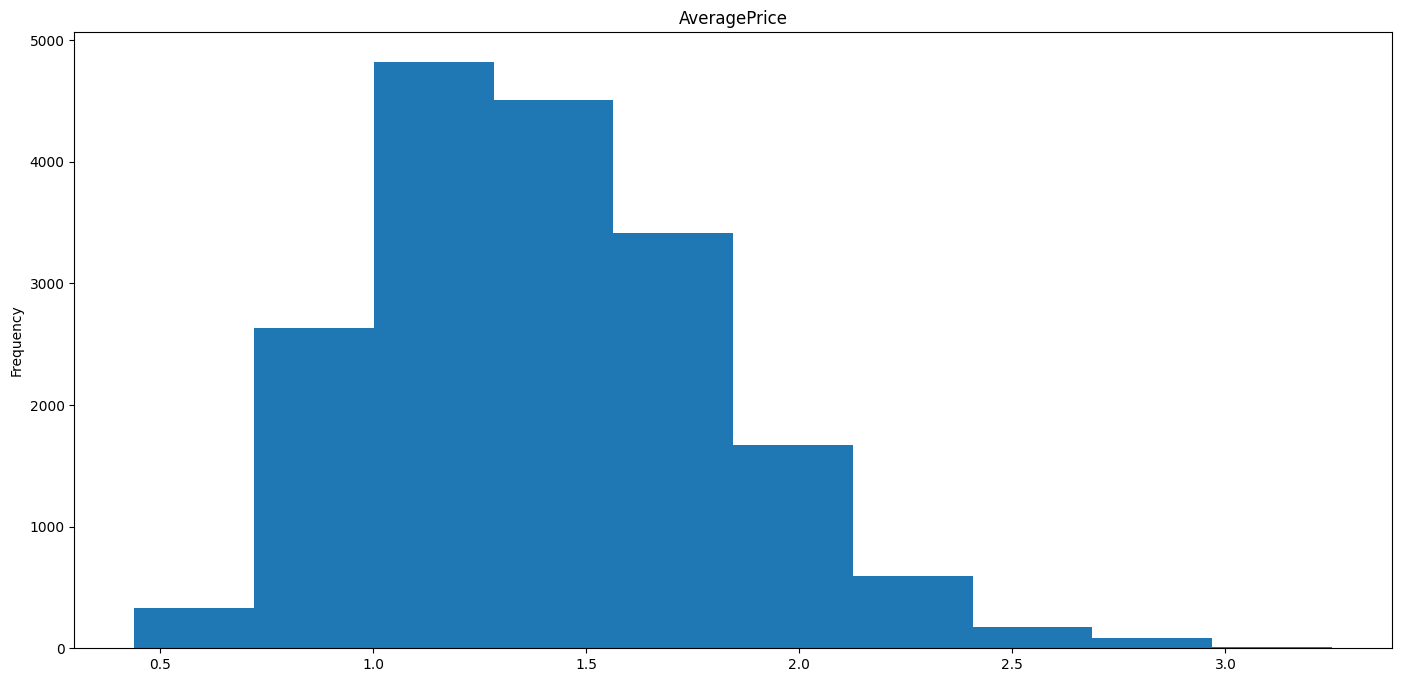

In [41]:
plt.figure(figsize=(17,8))
data["AveragePrice"].plot(kind = "hist");
plt.title("AveragePrice");

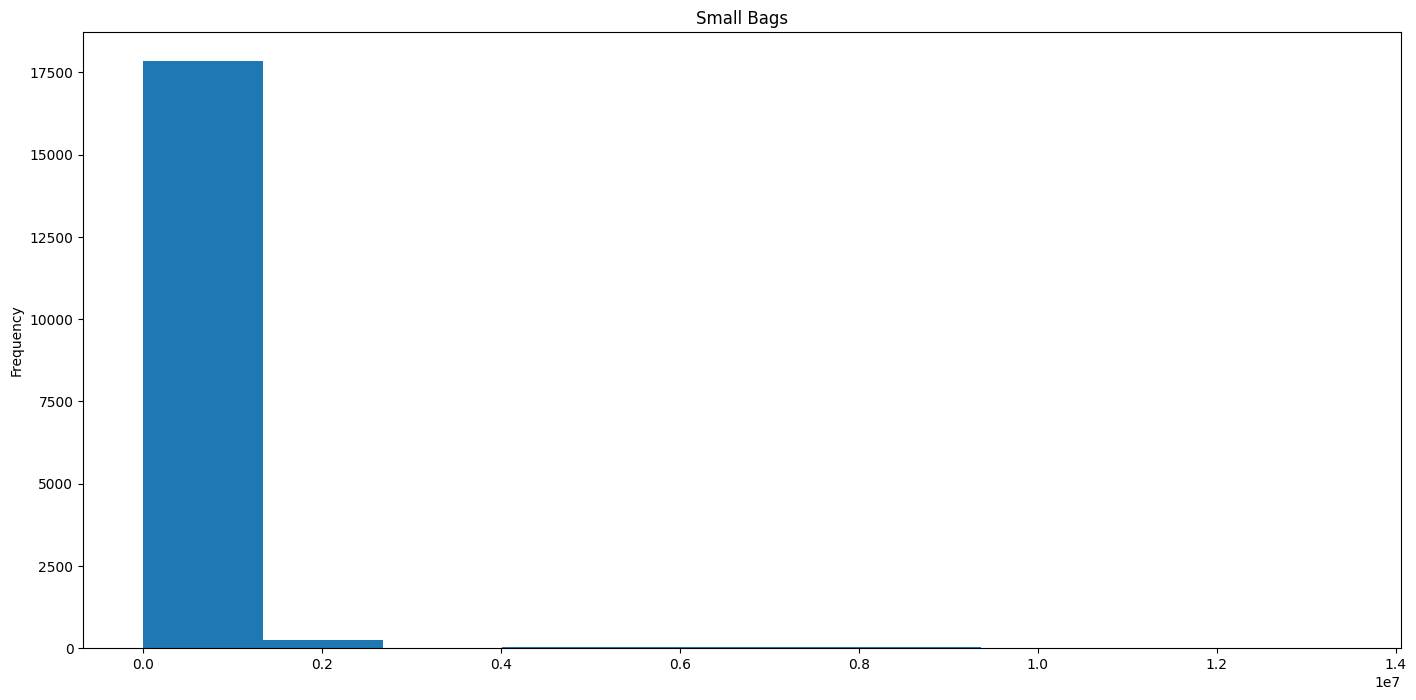

In [42]:
plt.figure(figsize=(17,8))
data["Small Bags"].plot(kind = "hist");
plt.title("Small Bags");

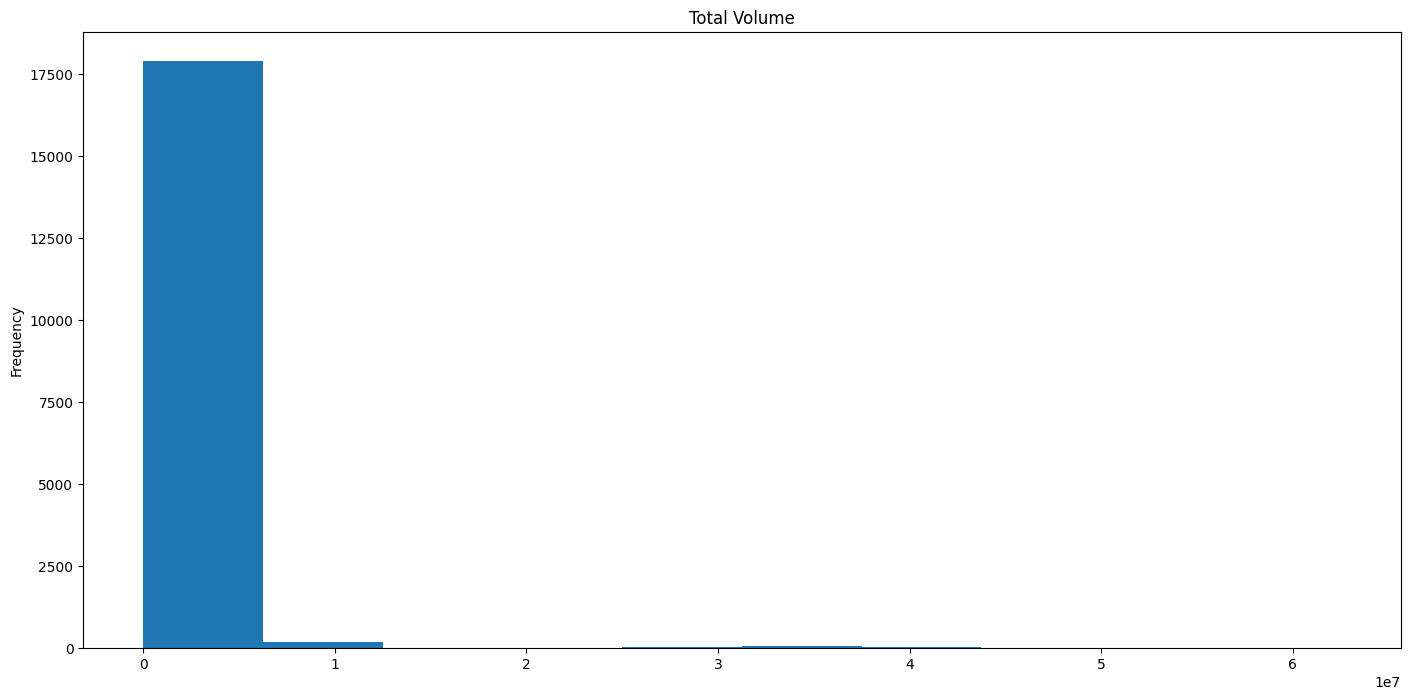

In [43]:
plt.figure(figsize=(17,8))
data["Total Volume"].plot(kind = "hist");
plt.title("Total Volume");

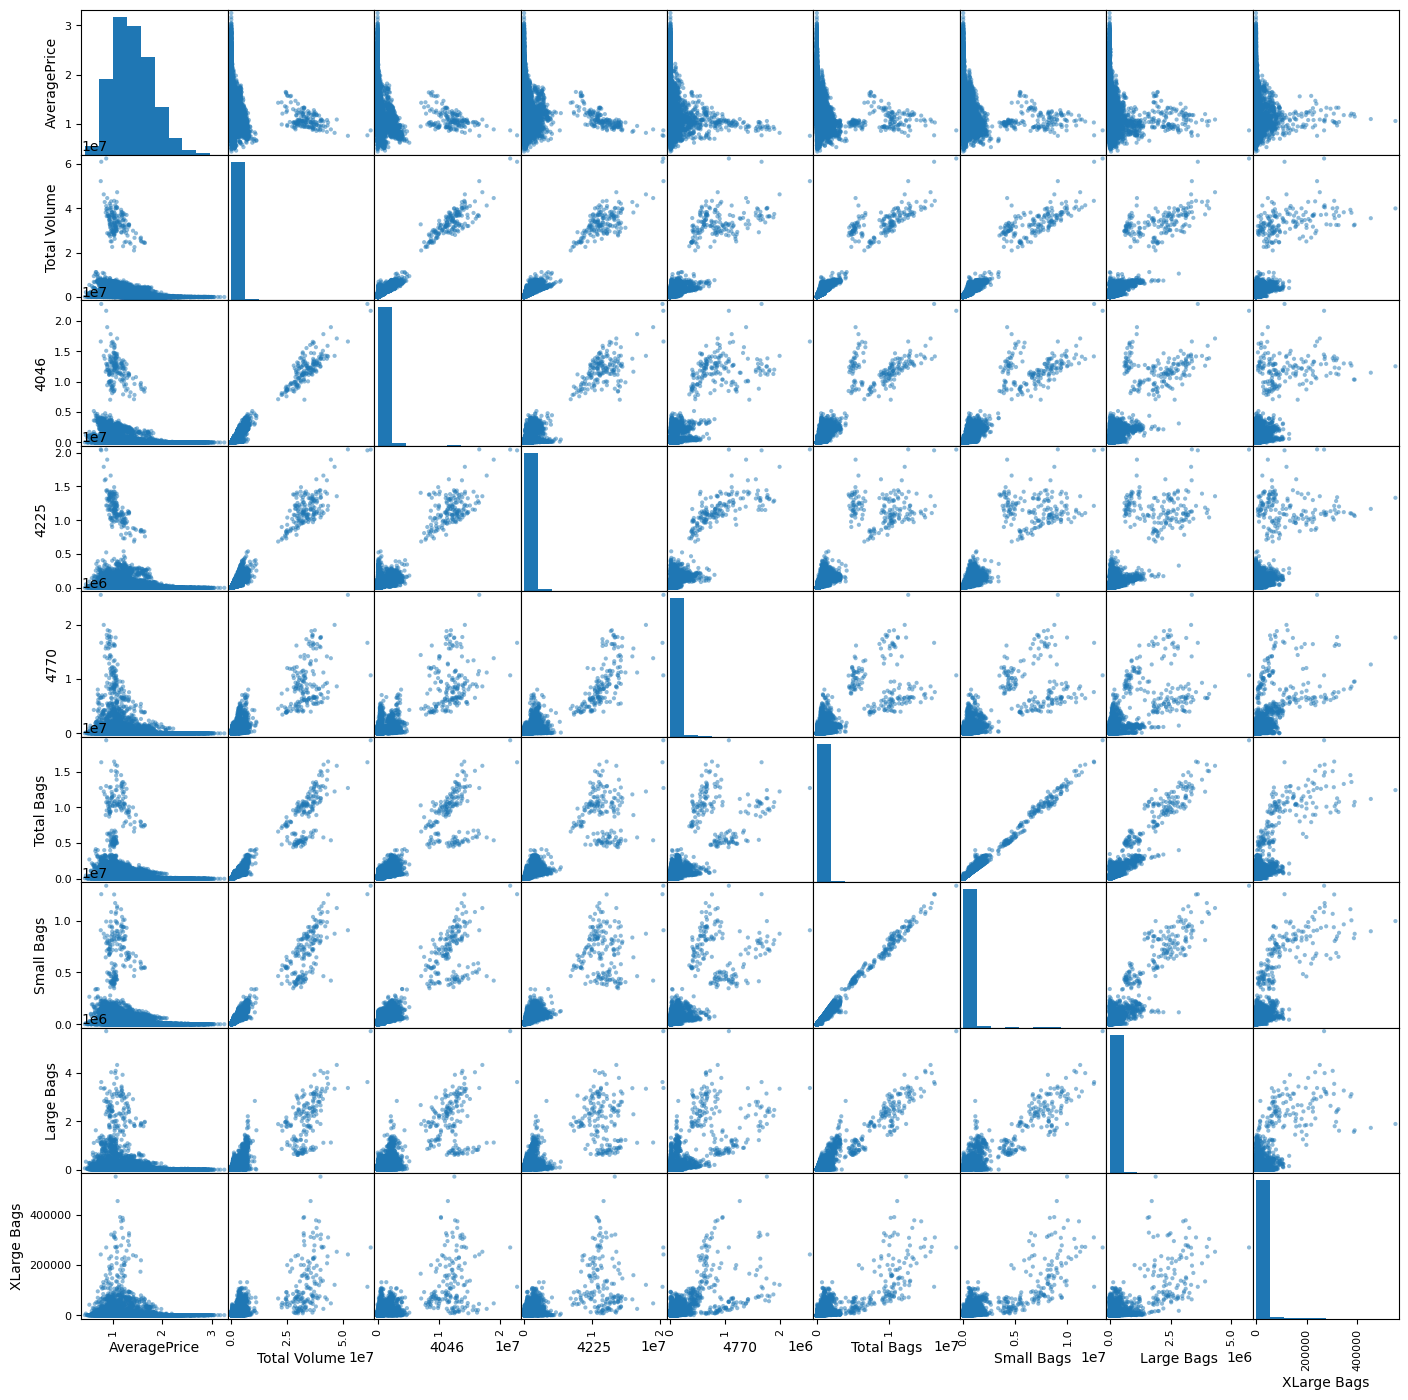

In [44]:
scatter_matrix(data, figsize = (17, 17));

In [45]:
data.corr()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
AveragePrice,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592
Total Volume,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157
4046,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377
4225,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809
4770,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861
Total Bags,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233
Small Bags,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845
Large Bags,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858
XLarge Bags,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000


Бачимо дуже сильну лінійну залежність між Small Bags та Total Bags


Покажемо загальну ціну для елементів категоривальних атрибутів type та region

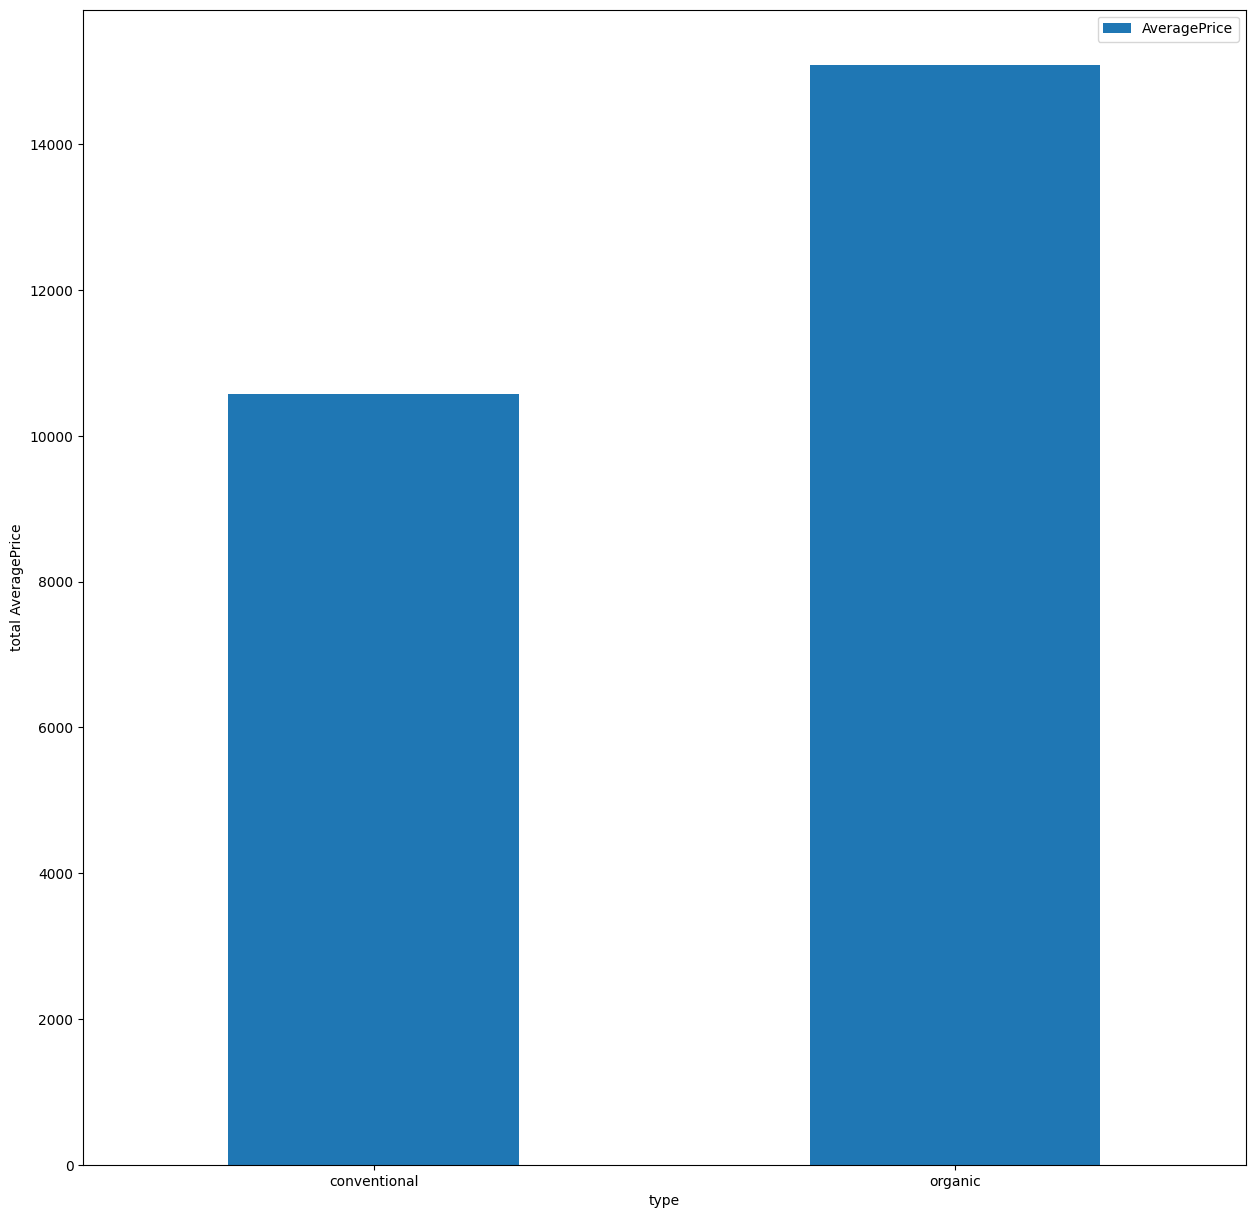

In [46]:
type_info = data[["AveragePrice"] + ["type"]].groupby("type").sum()
type_info.plot(kind = "bar", figsize =(15, 15), rot = 0);
plt.xlabel("type");
plt.ylabel("total AveragePrice");

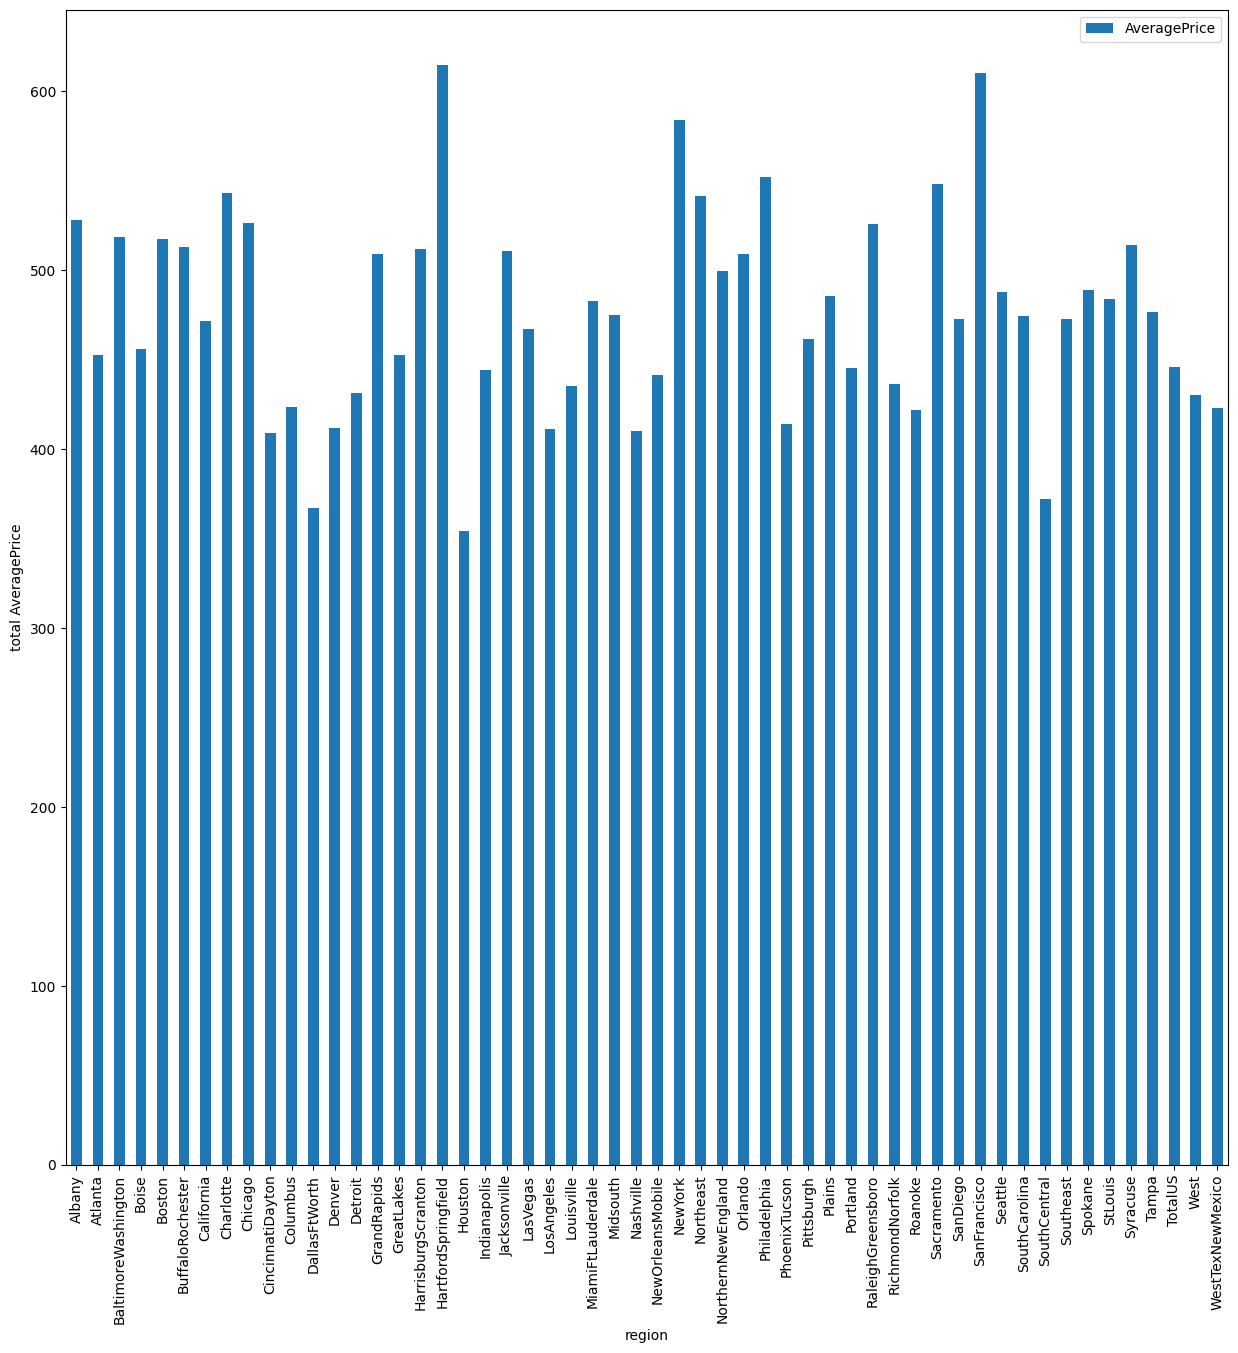

In [47]:
type_info = data[["AveragePrice"] + ["region"]].groupby("region").sum()
type_info.plot(kind = "bar", figsize =(15, 15));
plt.xlabel("region");
plt.ylabel("total AveragePrice");

## Препроцесінг та розбиття датасету на навчальний та валідаційний набори

Обробимо категоріальні змінні та стандартизуємо дані

In [48]:
data_copy = data.copy()
data_copy = pd.get_dummies(data_copy)

not_target_attribs = data_copy.drop("AveragePrice", axis = 1).columns
not_target_attribs = list(not_target_attribs)

scaler = StandardScaler()
X = scaler.fit_transform(data_copy[not_target_attribs])
y = data_copy["AveragePrice"].to_numpy()

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Навчання та прогнози моделей¶

Покажемо результати моделі на навчальному наборі

In [50]:
%%time
avocado_mlp = MLPRegressor(hidden_layer_sizes=(100), random_state=42)
avocado_mlp.fit(X_train, y_train)

print_metrics(X_train, y_train, avocado_mlp)

R^2 :  0.9781
RMSE:  0.0597
MAE :  0.0463
MAPE:  0.035808242
CPU times: total: 24.2 s
Wall time: 9.74 s


In [51]:
print_metrics(X_val, y_val, avocado_mlp)

R^2 :  0.7387
RMSE:  0.2049
MAE :  0.1556
MAPE:  0.118334831


Отримали чудові результати на одношаровій нейронній мережі. Модель трохи перенавчена, але отриманого результату нам достатьньо. Додатково перевіримо двошарову модель. 

In [52]:
%%time
avocado_mlp = MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42)
avocado_mlp.fit(X_train, y_train)

print_metrics(X_train, y_train, avocado_mlp)

R^2 :  0.9891
RMSE:  0.0421
MAE :  0.033
MAPE:  0.025019786
CPU times: total: 22.4 s
Wall time: 8.71 s


In [53]:
print_metrics(X_val, y_val, avocado_mlp)

R^2 :  0.6931
RMSE:  0.2221
MAE :  0.1714
MAPE:  0.128322568


Двошарова НМ показала гірші результати на тестувальній виборці, зупинимось на одношаровій

## Підбір гіперпараметрів моделі


Будемо робити так само як і в попередньому пункті

In [54]:
parameters = {
    'hidden_layer_sizes' : [(250), (200), (150), (225)],
    'alpha'              : [100, 1000, 10000, 100000]
}

In [55]:
best_avocado_regr = MLPRegressor(random_state = 42, early_stopping = True)
best_avocado_regr = RandomizedSearchCV(best_avocado_regr, parameters, cv=5, scoring='neg_median_absolute_error')
best_avocado_regr.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=MLPRegressor(early_stopping=True, random_state=42),
                   param_distributions={'alpha': [100, 1000, 10000, 100000],
                                        'hidden_layer_sizes': [250, 200, 150,
                                                               225]},
                   scoring='neg_median_absolute_error')

In [56]:
#найкращі моделі
best_avocado_regr.best_params_

{'hidden_layer_sizes': 200, 'alpha': 100}

In [57]:
best_avocado_regr = best_avocado_regr.best_estimator_

In [58]:
print('Метрики на тренувальному наборі:')
print_metrics(X_train, y_train, best_avocado_regr)
print('---------------------------------------------')
print('Метрики на тестовому наборSі:')
print_metrics(X_val, y_val, best_avocado_regr)

Метрики на тренувальному наборі:
R^2 :  0.5317
RMSE:  0.2759
MAE :  0.2036
MAPE:  0.143717201
---------------------------------------------
Метрики на тестовому наборі:
R^2 :  0.5176
RMSE:  0.2784
MAE :  0.2067
MAPE:  0.145129823


Після подбору гіперпараметрів модель зі стандартними параметрами виявилась краще

## Висновки

    У ході виконання лабораторної роботи №3 було вирішено задачу регресії за допомогою sklearn.neural_network.MLPRegressor, а також оцінено якість отриманих нейронних мереж.
    Нейроні мережі показали гарний результат.Зазвичай краші ніж метож опорних векторів з минулої лабораторної работи.